# 2022-01-21 Rootfinding

* Office hours: Monday 9-10pm, Tuesday 2-3pm, Thursday 2-3pm
* Next week will stay virtual. Plan is to start in-person the following Monday (Jan 31)

## Last time

* More on floating point
* Discuss Taylor Series activity
* Condition numbers

## Today

* Forward and backward error
* Computing volume of a polygon
* Rootfinding examples
* Use [Roots.jl](https://juliapackages.com/p/roots) to solve
* Introduce Bisection

In [1]:
using Plots
default(linewidth=4)

# Reliable = well-conditioned and stable

## Mathematical functions $f(x)$ can be ill-conditioned (big $\kappa$)
* Modeling is how we turn an abstract question into a mathematical function
* We want well-conditioned models (small $\kappa$)
* Some systems are intrinsically sensitive: fracture, chaotic systems, combustion

## Algorithms `f(x)` can be unstable
* Unreliable, though sometimes practical
* Unstable algorithms are constructed from ill-conditioned parts

# An ill-conditioned problem from Paul Olum

From [Surely You're Joking, Mr. Feynman](https://sistemas.fciencias.unam.mx/%7Ecompcuantica/RICHARD%20P.%20FEYNMAN-SURELY%20YOU%27RE%20JOKING%20MR.%20FEYNMAN.PDF) (page 113)

> So Paul is walking past the lunch place and these guys are all excited. "Hey, 
Paul!" they call out. "Feynman's terrific! We give him a problem that can be stated in ten 
seconds, and in a minute he gets the answer to 10 percent. Why don't you give him one?" 
Without hardly stopping, he says, "The tangent of 10 to the 100th." 
I was sunk: you have to divide by pi to 100 decimal places! It was hopeless.

What's the condition number?

$$ \kappa = |f'(x)| \frac{|x|}{|f|} $$

* $f(x) = \tan x$
* $f'(x) = 1 + \tan^2 x$

$$ \kappa = \lvert x \rvert \Bigl( \lvert \tan x \rvert + \bigl\lvert \frac{1}{\tan x} \bigr\rvert \Bigr) > \lvert x \rvert$$

In [2]:
tan(1e100)

-0.4116229628832498

In [3]:
tan(BigFloat("1e100", precision=500))

0.4012319619908143541857543436532949583238702611292440683194415381168718098221194

# Forward and backward error



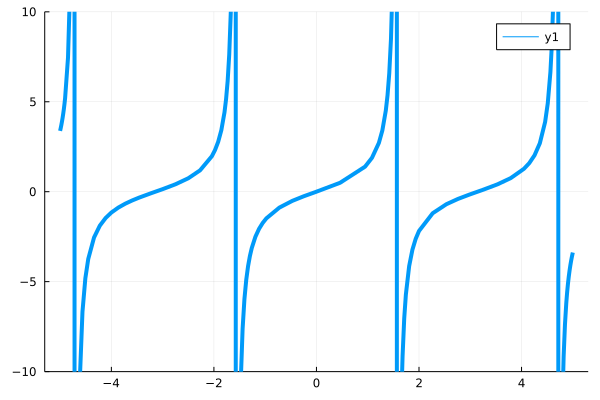

In [49]:
plot(tan, ylims=(-10, 10), x=LinRange(-10, 10, 1000))

## Read [Backward error](https://fncbook.github.io/fnc/intro/stability.html)

![](https://fncbook.github.io/fnc/_images/backwarderror.svg)

* For ill-conditioned functions, the best we can hope for is small backward error.

* Feynman could have answered with any real number and it would have a (relative) backward error less than $10^{-100}$. All the numbers we saw on the previous slide had tiny backward error because

$$ \texttt{tan} \big( \operatorname{fl}(\underbrace{10^{100}}_x) \big) = \tan \big( \underbrace{10^{100} (1 + \epsilon)}_{\tilde x} \big) $$

for some $\epsilon < 10^{-100}$. (All real numbers can be written this way for some small $\epsilon$.)

# Go find some functions...

* Find a function $f(x)$ that models something you're interested in
* Plot its condition number $\kappa$ as a function of $x$
* Plot the relative error (using single or double precision; compare using Julia's `big`)
* Is the relative error ever much bigger than $\kappa \epsilon_{\text{machine}}$?
* Can you find what caused the instability?
* Share on Zulip

## Further reading: [FNC Introduction](https://fncbook.github.io/fnc/intro/overview.html)

# Stability demo: Volume of a polygon

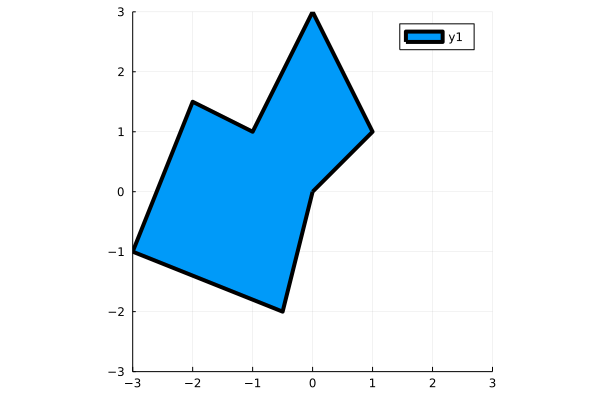

In [115]:
X = [1 0; 2 1; 1 3; 0 1; -1 1.5; -2 -1; .5 -2; 1 0]
R(θ) = [cos(θ) -sin(θ); sin(θ) cos(θ)]
Y = X * R(deg2rad(0))' .+ [-1 0]
plot(Y[:,1], Y[:,2], seriestype=:shape, aspect_ratio=:equal, xlims=(-3, 3), ylims=(-3, 3))

In [112]:
using LinearAlgebra
function pvolume(X)
    n = size(X, 1)
    vol = sum(det(X[i:i+1, :] .- X[1:1, :]) / 2 for i in 1:n-1)
end

@show ref = pvolume(Y)
[det(Y[i:i+1, :]) for i in 1:size(Y, 1)-1]

ref = pvolume(Y) = 9.25


7-element Vector{Float64}:
 -9.99999990197677e7
  4.000000050197677e8
  2.9802322685718536
  2.5e8
 -4.999999353953558e7
 -5.999999940593033e8
  9.999999801976773e7

What happens if this polygon is translated, perhaps far away?

# Rootfinding

> Given $f(x)$, find $x$ such that $f(x) = 0$.

We'll work with scalars ($f$ and $x$ are just numbers) for now, and revisit later when they vector-valued.

## Change inputs to outputs

* $f(x; b) = x^2 - b$
  * $x(b) = \sqrt{b}$
* $f(x; b) = \tan x - b$
  * $x(b) = \arctan b$
* $f(x) = \cos x + x - b$
  * $x(b) = ?$

We aren't given $f(x)$, but rather an algorithm `f(x)` that approximates it.
* Sometimes we get extra information, like `fp(x)` that approximates $f'(x)$
* If we have source code for `f(x)`, maybe it can be transformed "automatically"

# Example: Queueing

In a [simple queueing model](https://en.wikipedia.org/wiki/Queueing_theory#Simple_two-equation_queue), there is an arrival rate and a departure (serving) rate.  While waiting in the queue, there is a probability of "dropping out". The length of the queue in this model is

$$ \text{length} = \frac{\text{arrival} - \text{drop}}{\text{departure}} $$

One model for the waiting time (where these rates are taken from exponential distributions) is

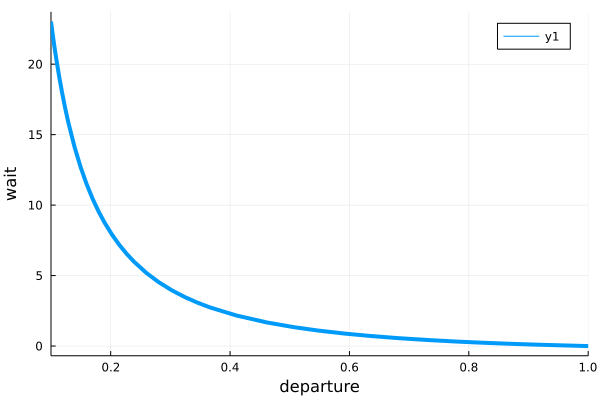

In [80]:
wait(arrival, departure) = log(arrival / departure) / departure

plot(d -> wait( , d), xlims=(.1, 1), xlabel="departure", ylabel="wait")

# Departure rate given wait

* Easy to measure wait
* I have a limited tolerance for waiting

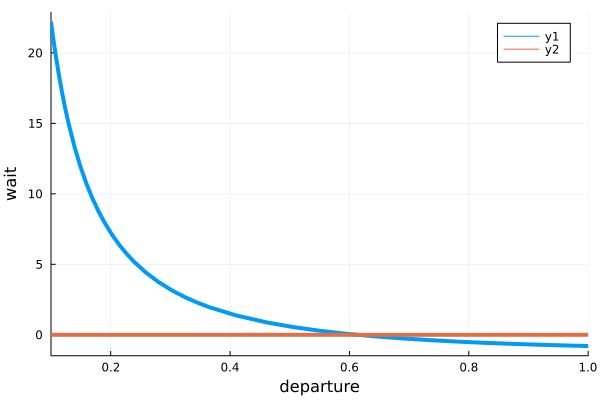

In [83]:
my_wait = 0.8
plot([d -> wait(1, d) - my_wait, d -> 0], xlims=(.1, 1), xlabel="departure", ylabel="wait")

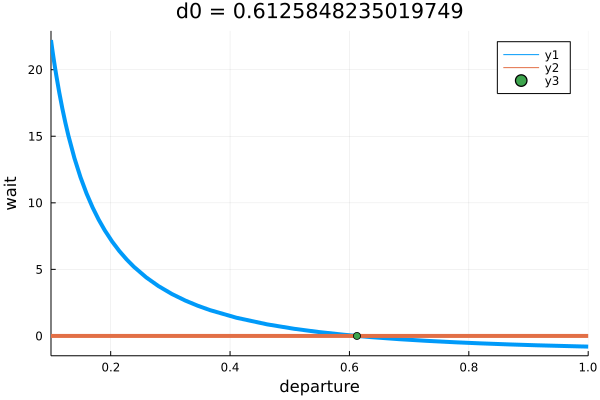

In [84]:
using Roots
d0 = find_zero(d -> wait(1, d) - my_wait, 1)
scatter!([d0], [0], marker=(:circle), title="d0 = $d0")

# Example: Nonlinear Elasticity

### Strain-energy formulation

$$ W = C_1 (I_1 - 3 - 2 \log J) + D_1 (J - 1)^2 $$
where $I_1 = \lambda_1^2 + \lambda_2^2 + \lambda_3^3$ and $J = \lambda_1 \lambda_2 \lambda_3$ are *invariants* defined in terms of the principle stretches $\lambda_i$.

#### [Uniaxial extension](https://en.wikipedia.org/wiki/Neo-Hookean_solid#Compressible_neo-Hookean_material_3)

In the experiment, we would like to know the stress as a function of the stretch $\lambda_1$. We don't know $J$, and will have to determine it by solving an equation.

https://www.youtube.com/watch?v=9N5SS8f1auI&t=60

# How much does the volume change?

Using symmetries of uniaxial extension, we can write an equation $f(\lambda, J) = 0$ that must be satisfied. We'll need to solve a rootfinding problem to compute $J(\lambda)$.

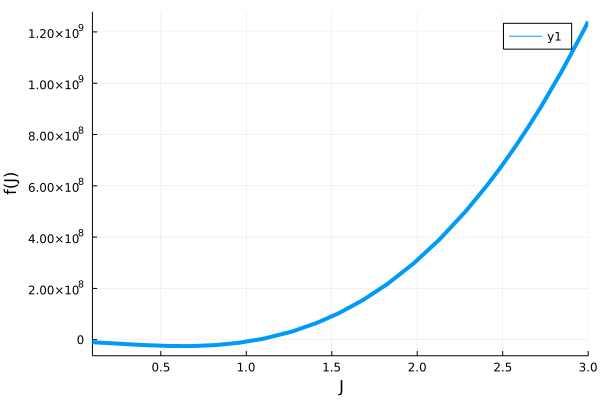

In [85]:
function f(lambda, J)
    C_1 = 1.5e6
    D_1 = 1e8
    D_1 * J^(8/3) - D_1 * J^(5/3) + C_1 / (3*lambda) * J - C_1 * lambda^2/3
end
plot(J -> f(4, J), xlims=(0.1, 3), xlabel="J", ylabel="f(J)")

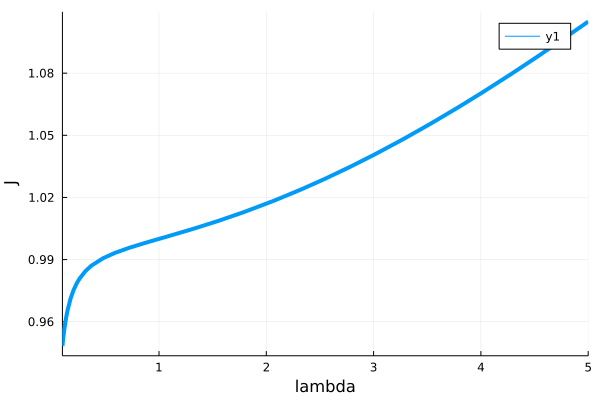

In [86]:
find_J(lambda) = find_zero(J -> f(lambda, J), 1)
plot(find_J, xlims=(0.1, 5), xlabel="lambda", ylabel="J")

# An algorithm: Bisection

Bisection is a rootfinding technique that starts with an interval $[a,b]$ containing a root and does not require derivatives. Suppose $f$ is continuous. What is a **sufficient** condition for $f$ to have a root on $[a,b]$?

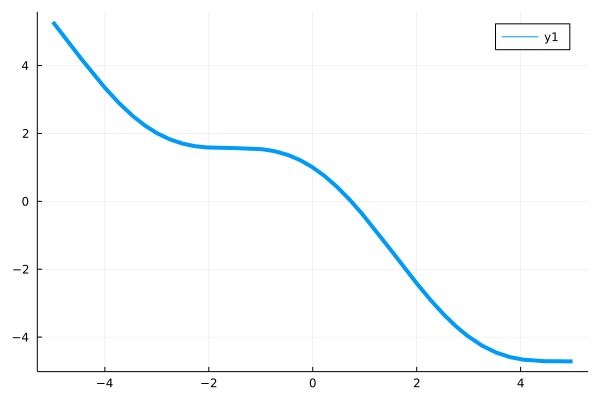

In [87]:
hasroot(f, a, b) = f(a) * f(b) < 0

f(x) = cos(x) - x
plot(f)

# Bisection

In [88]:
function bisect(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return mid
    elseif hasroot(f, a, mid)
        return bisect(f, a, mid, tol)
    else
        return bisect(f, mid, b, tol)
    end
end

x0 = bisect(f, -1, 3, 1e-5)
x0, f(x0)

(0.7390861511230469, -1.7035832658995886e-6)

# How fast does it converge?

In [89]:
function bisect_hist(f, a, b, tol)
    mid = (a + b) / 2
    if abs(b - a) < tol
        return [mid]
    elseif hasroot(f, a, mid)
        return prepend!(bisect_hist(f, a, mid, tol), [mid])
    else
        return prepend!(bisect_hist(f, mid, b, tol), [mid])
    end
end

bisect_hist (generic function with 1 method)

In [90]:
bisect_hist(f, -1, 3, 1e-4)

17-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125
 0.739105224609375

# Iterative bisection

* Data structures often optimized for appending rather than prepending.
* Bounds stack space

In [91]:
function bisect_iter(f, a, b, tol)
    hist = Float64[]
    while abs(b - a) > tol
        mid = (a + b) / 2
        push!(hist, mid)
        if hasroot(f, a, mid)
            b = mid
        else
            a = mid
        end
    end
    hist
end

bisect_iter (generic function with 1 method)

In [92]:
bisect_iter(f, -1, 3, 1e-4)

16-element Vector{Float64}:
 1.0
 0.0
 0.5
 0.75
 0.625
 0.6875
 0.71875
 0.734375
 0.7421875
 0.73828125
 0.740234375
 0.7392578125
 0.73876953125
 0.739013671875
 0.7391357421875
 0.73907470703125

# Let's plot the error

$$ \lvert \texttt{bisect}^k(f, a, b) - r \rvert, \quad k = 1, 2, \dotsc $$

where $r$ is the true root, $f(r) = 0$.

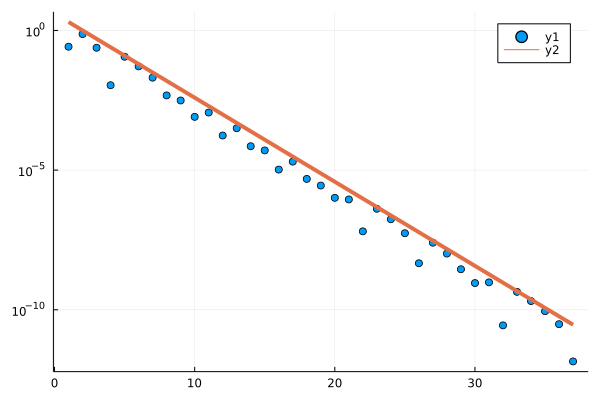

In [102]:
r = bisect(f, -1, 3, 1e-14) # what are we trusting?
hist = bisect_hist(f, -1, 3, 1e-10)
scatter( abs.(hist .- r), yscale=:log10)
ks = 1:length(hist)
plot!(ks, 4 * (.5 .^ ks))

Evidently the error $e_k = x_k - x_*$ after $k$ bisections satisfies the bound
$$ |e^k| \le c 2^{-k} . $$

# Next time

* Discuss rootfinding examples
* Limitations of bisection
* Convergence classes
* Newton methods
  * convergence theory
  * derivation via convergence theory
  * reliability

## For you

* Share an equation that is useful for one task, but requires rootfinding for another task.
* OR: explain a system in which one stakeholder has the natural inputs, but a different stakeholder only knows outputs.

Please collaborate.